In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class PlatinumBVARForecast:
    def __init__(self, base_year=2017, lags=2):
        self.base_year = base_year
        self.lags = lags
        self.model = None
        self.idata = None
        self.train_df = None
        self.test_df = None
        self.forecast_df = None
        self.var_names = None
        
    def prepare_data(self):
        """Prepare platinum price and economic indicator data"""
        # Platinum price data with economic indicators
        data = [
            [1988, 523, 59.5, 4.6, 85.2], [1989, 507, 62.3, 3.7, 87.1],
            [1990, 466, 65.6, 2.9, 88.3], [1991, 372, 68.4, 1.4, 86.9],
            [1992, 357, 70.5, 2.2, 88.7], [1993, 373, 72.3, 2.6, 90.1],
            [1994, 405, 74.8, 3.0, 92.4], [1995, 425, 76.8, 2.7, 94.2],
            [1996, 397, 79.0, 3.4, 95.8], [1997, 394, 80.8, 3.8, 97.1],
            [1998, 372, 81.5, 2.7, 95.3], [1999, 377, 83.4, 3.4, 96.8],
            [2000, 544, 86.3, 4.8, 98.2], [2001, 533, 88.1, 2.5, 97.1],
            [2002, 540, 89.6, 3.1, 98.9], [2003, 692, 91.8, 4.0, 101.3],
            [2004, 844, 94.7, 4.5, 104.8], [2005, 897, 97.1, 4.3, 107.2],
            [2006, 1142, 99.8, 4.5, 110.1], [2007, 1304, 102.6, 4.4, 112.8],
            [2008, 1578, 104.2, 1.9, 108.9], [2009, 1205, 104.5, -1.3, 101.2],
            [2010, 1613, 106.7, 4.3, 106.8], [2011, 1722, 109.7, 3.1, 109.4],
            [2012, 1552, 111.4, 2.6, 108.7], [2013, 1487, 112.8, 2.8, 107.3],
            [2014, 1385, 114.1, 2.9, 105.9], [2015, 1054, 115.4, 3.2, 102.1],
            [2016, 990, 117.1, 3.1, 101.8], [2017, 954, 119.3, 3.0, 100.0],
            [2018, 879, 121.7, 2.9, 98.7], [2019, 863, 124.0, 2.8, 97.9],
            [2020, 883, 126.3, -3.5, 95.4], [2021, 1077, 129.6, 5.6, 98.2],
            [2022, 1016, 133.8, 3.1, 99.1], [2023, 1077, 136.9, 2.9, 100.3],
            [2024, 960, 139.5, 2.8, 99.8], [2025, 1020, 142.1, 2.7, 100.5]
        ]
        
        df = pd.DataFrame(data, columns=[
            'Year', 'Nominal_Platinum_Price_USD_oz', 'US_CPI_2017_100', 
            'Global_GDP_Growth_pct', 'Industrial_Production_Index'
        ]).set_index('Year')
        
        # Removing the CPI impact
        df['Real_Platinum_Price'] = (df['Nominal_Platinum_Price_USD_oz'] / df['US_CPI_2017_100'] 
                                   * df.loc[self.base_year, 'US_CPI_2017_100'])
        
        # Log transform variables for stationarity
        df['Log_Real_Price'] = np.log(df['Real_Platinum_Price'])
        df['Log_Industrial_Production'] = np.log(df['Industrial_Production_Index'])
        
        # Create growth rates (first differences of logs)
        df['Price_Growth'] = df['Log_Real_Price'].diff()
        df['GDP_Growth_Rate'] = df['Global_GDP_Growth_pct']  # Already in percentage
        df['Industrial_Growth'] = df['Log_Industrial_Production'].diff()
        
        # Select variables for VAR model
        self.var_names = ['Price_Growth', 'GDP_Growth_Rate', 'Industrial_Growth']
        
        # Create training and test sets
        self.train_df = df[df.index <= 2020].copy()
        self.test_df = df[df.index > 2020].copy()
        
        print(f"Data prepared: {len(self.train_df)} training observations, {len(self.test_df)} test observations")
        print(f"VAR variables: {self.var_names}")
        
        return df
    
    def prepare_bvar_data(self):
        """Prepare data for BVAR estimation"""
        if self.train_df is None:
            raise ValueError("Must call prepare_data() first")
        
        # Get clean data (remove NaN values)
        var_data = self.train_df[self.var_names].dropna()
        
        n_obs, n_vars = var_data.shape
        
        # Create lagged variables
        Y = []  # Dependent variables
        X = []  # Lagged independent variables
        
        for t in range(self.lags, n_obs):
            # Current period values (dependent variables)
            Y.append(var_data.iloc[t].values)
            
            # Lagged values (independent variables) + constant
            x_t = [1.0]  # constant term
            for lag in range(1, self.lags + 1):
                x_t.extend(var_data.iloc[t - lag].values)
            X.append(x_t)
        
        self.Y = np.array(Y)  # Shape: (T-lags, n_vars)
        self.X = np.array(X)  # Shape: (T-lags, 1 + n_vars*lags)
        
        # Store last observations for forecasting
        self.last_obs = var_data.iloc[-self.lags:].values
        
        print(f"BVAR data prepared: {self.Y.shape[0]} observations, {self.Y.shape[1]} variables")
        print(f"Number of parameters per equation: {self.X.shape[1]}")
        
    def build_and_train_bvar(self):
        """Build and train the BVAR model"""
        if not hasattr(self, 'Y'):
            raise ValueError("Must call prepare_bvar_data() first")
        
        print("Building and training BVAR model...")
        
        n_obs, n_vars = self.Y.shape
        n_params = self.X.shape[1]
        
        with pm.Model() as self.model:
            # Minnesota prior parameters
            lambda1 = 0.1  # Overall tightness
            lambda2 = 0.5  # Cross-variable relative to own variable
            lambda3 = 1.0  # Higher lag relative to lower lag
            
            # Coefficient matrices for each equation
            coefficients = []
            sigma_diag = []
            
            for i in range(n_vars):
                # Priors for coefficients in equation i
                coef_prior_std = []
                
                # Constant term
                coef_prior_std.append(1.0)
                
                # Lagged coefficients
                for lag in range(1, self.lags + 1):
                    for j in range(n_vars):
                        if i == j:  # Own lag
                            if lag == 1:
                                std = lambda1  # First own lag
                            else:
                                std = lambda1 * (lambda3 ** (lag - 1))
                        else:  # Cross-variable lag
                            std = lambda1 * lambda2 * (lambda3 ** (lag - 1))
                        coef_prior_std.append(std)
                
                # Coefficient vector for equation i
                beta_i = pm.Normal(f'beta_{i}', mu=0, sigma=coef_prior_std, shape=n_params)
                coefficients.append(beta_i)
                
                # Error variance for equation i
                sigma_i = pm.HalfNormal(f'sigma_{i}', sigma=0.1)
                sigma_diag.append(sigma_i)
            
            # Stack coefficients
            beta_matrix = pm.math.stack(coefficients, axis=0)  # Shape: (n_vars, n_params)
            
            # Predictions
            mu = pm.math.dot(self.X, beta_matrix.T)  # Shape: (n_obs, n_vars)
            
            # Likelihood for each variable
            for i in range(n_vars):
                pm.Normal(f'y_{i}', mu=mu[:, i], sigma=sigma_diag[i], 
                         observed=self.Y[:, i])
            
            # Sample from posterior
            self.idata = pm.sample(1000, tune=500, chains=2, cores=1,
                                 target_accept=0.85, random_seed=42,
                                 progressbar=True)
        
        print("BVAR model training completed!")
        return self.idata
    
    def generate_forecasts(self, forecast_years=None):
        """Generate forecasts using the trained BVAR model"""
        if forecast_years is None:
            forecast_years = list(range(2021, 2061))
        
        if self.idata is None:
            raise ValueError("Must train model first")
        
        print(f"Generating BVAR forecasts for {len(forecast_years)} years...")
        
        # Extract posterior samples
        posterior = self.idata.posterior
        n_vars = len(self.var_names)
        
        # Initialize forecast arrays
        forecasts = {var: [] for var in self.var_names}
        forecast_intervals = {var: {'lower': [], 'upper': []} for var in self.var_names}
        
        # Current state (last observations)
        current_state = self.last_obs.copy()
        
        for year_idx, year in enumerate(forecast_years):
            # Forecast distributions for this period
            forecast_dist = {var: [] for var in self.var_names}
            
            # Sample from posterior predictive
            for chain in range(len(posterior.chain)):
                for draw in range(len(posterior.draw)):
                    # Get parameters for this draw
                    coeffs = []
                    sigmas = []
                    for i in range(n_vars):
                        beta_i = posterior[f'beta_{i}'].values[chain, draw]
                        sigma_i = posterior[f'sigma_{i}'].values[chain, draw]
                        coeffs.append(beta_i)
                        sigmas.append(sigma_i)
                    
                    # Construct X vector for prediction
                    x_pred = [1.0]  # constant
                    for lag in range(1, self.lags + 1):
                        if lag <= len(current_state):
                            x_pred.extend(current_state[-lag])
                        else:
                            x_pred.extend(np.zeros(n_vars))
                    
                    x_pred = np.array(x_pred)
                    
                    # Predict each variable
                    for i in range(n_vars):
                        mu_pred = np.dot(x_pred, coeffs[i])
                        y_pred = np.random.normal(mu_pred, sigmas[i])
                        forecast_dist[self.var_names[i]].append(y_pred)
            
            # Calculate point forecasts and intervals
            for i, var in enumerate(self.var_names):
                point_forecast = np.median(forecast_dist[var])
                lower_ci = np.percentile(forecast_dist[var], 2.5)
                upper_ci = np.percentile(forecast_dist[var], 97.5)
                
                forecasts[var].append(point_forecast)
                forecast_intervals[var]['lower'].append(lower_ci)
                forecast_intervals[var]['upper'].append(upper_ci)
            
            # Update current state for next period
            new_obs = np.array([forecasts[var][-1] for var in self.var_names])
            current_state = np.vstack([current_state, new_obs])
            if len(current_state) > self.lags:
                current_state = current_state[-self.lags:]
        
        # Convert price growth back to price levels
        last_log_price = self.train_df['Log_Real_Price'].iloc[-1]
        price_levels = []
        price_lower = []
        price_upper = []
        
        current_log_price = last_log_price
        for i in range(len(forecast_years)):
            current_log_price += forecasts['Price_Growth'][i]
            price_levels.append(np.exp(current_log_price))
            
            # For confidence intervals, apply cumulative growth
            cumulative_growth = sum(forecasts['Price_Growth'][:i+1])
            lower_growth = sum(forecast_intervals['Price_Growth']['lower'][:i+1])
            upper_growth = sum(forecast_intervals['Price_Growth']['upper'][:i+1])
            
            price_lower.append(np.exp(last_log_price + lower_growth))
            price_upper.append(np.exp(last_log_price + upper_growth))
        
        # Create forecast dataframe
        self.forecast_df = pd.DataFrame({
            'Year': forecast_years,
            'Forecasted_Price': price_levels,
            'Lower_CI': price_lower,
            'Upper_CI': price_upper,
            'GDP_Growth_Forecast': forecasts['GDP_Growth_Rate'],
            'Industrial_Growth_Forecast': forecasts['Industrial_Growth']
        }).set_index('Year')
        
        print("BVAR forecast generation completed!")
        return self.forecast_df
    
    def save_forecast_to_csv(self, filename='platinum_price_forecast.csv'):
        """Save forecast results to CSV file"""
        if self.forecast_df is None:
            raise ValueError("No forecasts available. Run generate_forecasts() first.")
        
        # Create a simplified CSV with Year and Platinum Price
        csv_data = pd.DataFrame({
            'Year': self.forecast_df.index,
            'Platinum_Price_USD_oz': self.forecast_df['Forecasted_Price'].round(2)
        })
        
        # Save to CSV
        csv_data.to_csv(filename, index=False)
        print(f"\nForecast results saved to: {filename}")
        
        # Display the CSV content
        print("\n=== PLATINUM PRICE FORECAST CSV CONTENT ===")
        print(csv_data.to_string(index=False))
        
        return csv_data
    
    def save_detailed_forecast_to_csv(self, filename='platinum_detailed_forecast.csv'):
        """Save detailed forecast results to CSV file"""
        if self.forecast_df is None:
            raise ValueError("No forecasts available. Run generate_forecasts() first.")
        
        # Create detailed CSV with confidence intervals
        
        detailed_csv = pd.DataFrame({
            'Year': self.forecast_df.index,
            'Platinum_Price_USD_oz': self.forecast_df['Forecasted_Price'].round(2),
            'Lower_95_CI': self.forecast_df['Lower_CI'].round(2),
            'Upper_95_CI': self.forecast_df['Upper_CI'].round(2),
            'GDP_Growth_Forecast_pct': self.forecast_df['GDP_Growth_Forecast'].round(2),
            'Industrial_Growth_Forecast_pct': self.forecast_df['Industrial_Growth_Forecast'].round(2)
        })
        
        # Save to CSV
        detailed_csv.to_csv(filename, index=False)
        print(f"\nDetailed forecast results saved to: {filename}")
        
        return detailed_csv
    
    def run_full_analysis_and_export(self):
        """Run complete BVAR analysis and export results"""
        print("=== Platinum Price Forecasting: BVAR Analysis ===\n")
        
        print("1. Preparing data...")
        self.prepare_data()
        self.prepare_bvar_data()
        
        print("\n2. Training BVAR model...")
        self.build_and_train_bvar()
        
        print("\n3. Generating forecasts...")
        self.generate_forecasts()
        
        print("\n4. Exporting forecast results...")
        simple_csv = self.save_forecast_to_csv('platinum_price_forecast.csv')
        detailed_csv = self.save_detailed_forecast_to_csv('platinum_detailed_forecast.csv')
        
        print("\n=== FORECAST SUMMARY ===")
        print(f"Forecast period: 2021-2060")
        print(f"Average forecasted price (2026-2060): ${self.forecast_df.loc[2026:2060, 'Forecasted_Price'].mean():,.2f}")
        print(f"Price range (2026-2060): ${self.forecast_df.loc[2026:2060, 'Forecasted_Price'].min():,.2f} - ${self.forecast_df.loc[2026:2060, 'Forecasted_Price'].max():,.2f}")
        
        # Show key forecast years
        key_years = [2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060]
        print("\n=== KEY FORECAST YEARS ===")
        print("Year    Price    Lower_CI  Upper_CI")
        print("-" * 35)
        for year in key_years:
            if year in self.forecast_df.index:
                price = self.forecast_df.loc[year, 'Forecasted_Price']
                lower = self.forecast_df.loc[year, 'Lower_CI']
                upper = self.forecast_df.loc[year, 'Upper_CI']
                print(f"{year}    ${price:6.2f}   ${lower:6.2f}   ${upper:6.2f}")
        
        return simple_csv, detailed_csv

# Execute the analysis and export
if __name__ == "__main__":
    forecaster = PlatinumBVARForecast(lags=2)
    simple_forecast, detailed_forecast = forecaster.run_full_analysis_and_export()
    
    print("\n" + "="*50)
    print("ANALYSIS COMPLETE!")
    print("Files generated:")
    print("1. platinum_price_forecast.csv (simple format)")
    print("2. platinum_detailed_forecast.csv (with confidence intervals)")
    print("="*50)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


=== Platinum Price Forecasting: BVAR Analysis ===

1. Preparing data...
Data prepared: 33 training observations, 5 test observations
VAR variables: ['Price_Growth', 'GDP_Growth_Rate', 'Industrial_Growth']
BVAR data prepared: 30 observations, 3 variables
Number of parameters per equation: 7

2. Training BVAR model...
Building and training BVAR model...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 434 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


BVAR model training completed!

3. Generating forecasts...
Generating BVAR forecasts for 40 years...
BVAR forecast generation completed!

4. Exporting forecast results...

Forecast results saved to: platinum_price_forecast.csv

=== PLATINUM PRICE FORECAST CSV CONTENT ===
 Year  Platinum_Price_USD_oz
 2021                 796.57
 2022                 898.94
 2023                 918.84
 2024                 930.25
 2025                 931.79
 2026                 930.61
 2027                 937.49
 2028                 935.80
 2029                 935.04
 2030                 938.40
 2031                 939.67
 2032                 939.47
 2033                 946.09
 2034                 948.56
 2035                 955.59
 2036                 966.81
 2037                 974.99
 2038                 975.27
 2039                 976.19
 2040                 974.27
 2041                 978.43
 2042                 974.44
 2043                 985.31
 2044                 993.03
 20

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


Starting hyperparameter cross-validation...
Testing 9 hyperparameter combinations.
Testing combo 1/9: lambda1=0.05, lambda2=0.5, lambda3=1.0


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 362 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 303 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 302 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnos

Testing combo 2/9: lambda1=0.05, lambda2=0.7, lambda3=1.0


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 387 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 344 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 310 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnos

Testing combo 3/9: lambda1=0.05, lambda2=0.9, lambda3=1.0


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 464 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 430 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 364 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnos

Testing combo 4/9: lambda1=0.1, lambda2=0.5, lambda3=1.0


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 522 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 503 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 410 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnos

Testing combo 5/9: lambda1=0.1, lambda2=0.7, lambda3=1.0


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 556 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 522 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 394 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnos

Testing combo 6/9: lambda1=0.1, lambda2=0.9, lambda3=1.0


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 550 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 516 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 403 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnos

Testing combo 7/9: lambda1=0.2, lambda2=0.5, lambda3=1.0


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 559 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 529 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 430 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnos

Testing combo 8/9: lambda1=0.2, lambda2=0.7, lambda3=1.0


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 595 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 547 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 453 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnos

Testing combo 9/9: lambda1=0.2, lambda2=0.9, lambda3=1.0


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 549 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 532 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 427 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnos


Cross-validation complete!
Best hyperparameters found:
lambda1    0.050000
lambda2    0.500000
lambda3    1.000000
mse        0.016125
Name: 0, dtype: float64


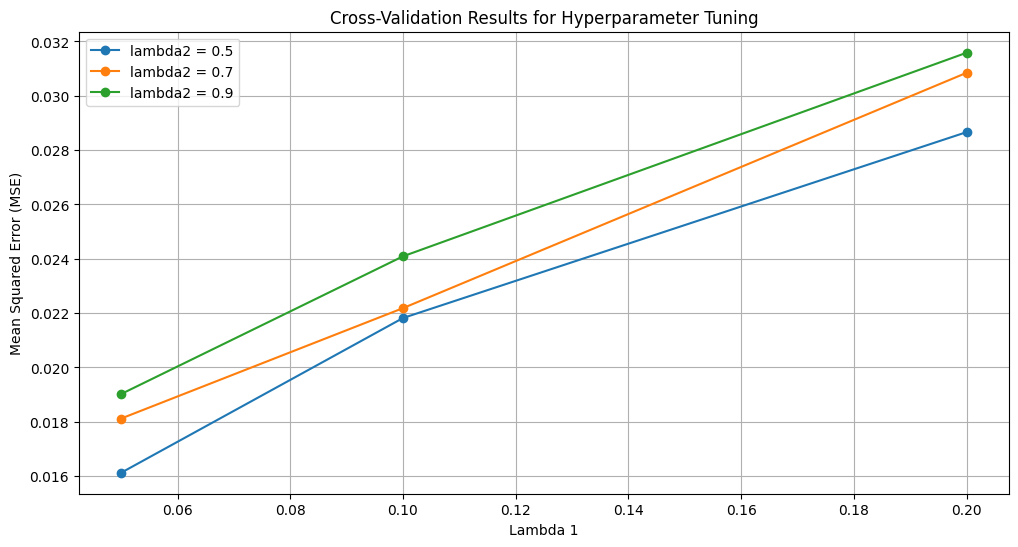


RUNNING FINAL ANALYSIS WITH BEST HYPERPARAMETERS

Training final model with best hyperparameters...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 455 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Generating final forecasts...
Generating BVAR forecasts for 40 years...
BVAR forecast generation completed!

ANALYSIS COMPLETE!


In [2]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
import itertools

warnings.filterwarnings('ignore')

class PlatinumBVARForecast:
    def __init__(self, base_year=2017, lags=2, lambda1=0.1, lambda2=0.5, lambda3=1.0):
        self.base_year = base_year
        self.lags = lags
        # Hyperparameters are now part of the class instance
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3
        self.model = None
        self.idata = None
        self.train_df = None
        self.test_df = None
        self.forecast_df = None
        self.var_names = None

    def prepare_data(self):
        """Prepare platinum price and economic indicator data"""
        # Data preparation remains the same
        data = [
            [1988, 523, 59.5, 4.6, 85.2], [1989, 507, 62.3, 3.7, 87.1],
            [1990, 466, 65.6, 2.9, 88.3], [1991, 372, 68.4, 1.4, 86.9],
            [1992, 357, 70.5, 2.2, 88.7], [1993, 373, 72.3, 2.6, 90.1],
            [1994, 405, 74.8, 3.0, 92.4], [1995, 425, 76.8, 2.7, 94.2],
            [1996, 397, 79.0, 3.4, 95.8], [1997, 394, 80.8, 3.8, 97.1],
            [1998, 372, 81.5, 2.7, 95.3], [1999, 377, 83.4, 3.4, 96.8],
            [2000, 544, 86.3, 4.8, 98.2], [2001, 533, 88.1, 2.5, 97.1],
            [2002, 540, 89.6, 3.1, 98.9], [2003, 692, 91.8, 4.0, 101.3],
            [2004, 844, 94.7, 4.5, 104.8], [2005, 897, 97.1, 4.3, 107.2],
            [2006, 1142, 99.8, 4.5, 110.1], [2007, 1304, 102.6, 4.4, 112.8],
            [2008, 1578, 104.2, 1.9, 108.9], [2009, 1205, 104.5, -1.3, 101.2],
            [2010, 1613, 106.7, 4.3, 106.8], [2011, 1722, 109.7, 3.1, 109.4],
            [2012, 1552, 111.4, 2.6, 108.7], [2013, 1487, 112.8, 2.8, 107.3],
            [2014, 1385, 114.1, 2.9, 105.9], [2015, 1054, 115.4, 3.2, 102.1],
            [2016, 990, 117.1, 3.1, 101.8], [2017, 954, 119.3, 3.0, 100.0],
            [2018, 879, 121.7, 2.9, 98.7], [2019, 863, 124.0, 2.8, 97.9],
            [2020, 883, 126.3, -3.5, 95.4], [2021, 1077, 129.6, 5.6, 98.2],
            [2022, 1016, 133.8, 3.1, 99.1], [2023, 1077, 136.9, 2.9, 100.3],
            [2024, 960, 139.5, 2.8, 99.8], [2025, 1020, 142.1, 2.7, 100.5]
        ]
        df = pd.DataFrame(data, columns=[
            'Year', 'Nominal_Platinum_Price_USD_oz', 'US_CPI_2017_100',
            'Global_GDP_Growth_pct', 'Industrial_Production_Index'
        ]).set_index('Year')
        df['Real_Platinum_Price'] = (df['Nominal_Platinum_Price_USD_oz'] / df['US_CPI_2017_100']
                                      * df.loc[self.base_year, 'US_CPI_2017_100'])
        df['Log_Real_Price'] = np.log(df['Real_Platinum_Price'])
        df['Log_Industrial_Production'] = np.log(df['Industrial_Production_Index'])
        df['Price_Growth'] = df['Log_Real_Price'].diff()
        df['GDP_Growth_Rate'] = df['Global_GDP_Growth_pct']
        df['Industrial_Growth'] = df['Log_Industrial_Production'].diff()
        self.var_names = ['Price_Growth', 'GDP_Growth_Rate', 'Industrial_Growth']
        self.train_df = df[df.index <= 2020].copy()
        self.test_df = df[df.index > 2020].copy()
        return df

    def prepare_bvar_data(self, data):
        """Prepare data for BVAR estimation from a given DataFrame."""
        var_data = data[self.var_names].dropna()
        n_obs, n_vars = var_data.shape
        Y, X = [], []
        for t in range(self.lags, n_obs):
            Y.append(var_data.iloc[t].values)
            x_t = [1.0]
            for lag in range(1, self.lags + 1):
                x_t.extend(var_data.iloc[t - lag].values)
            X.append(x_t)
        return np.array(Y), np.array(X)

    def build_and_train_bvar(self, Y, X):
        """Build and train the BVAR model using the provided data."""
        n_obs, n_vars = Y.shape
        n_params = X.shape[1]
        with pm.Model() as self.model:
            lambda1 = self.lambda1
            lambda2 = self.lambda2
            lambda3 = self.lambda3
            coefficients, sigma_diag = [], []
            for i in range(n_vars):
                coef_prior_std = [1.0]
                for lag in range(1, self.lags + 1):
                    for j in range(n_vars):
                        if i == j:
                            std = lambda1 if lag == 1 else lambda1 * (lambda3 ** (lag - 1))
                        else:
                            std = lambda1 * lambda2 * (lambda3 ** (lag - 1))
                        coef_prior_std.append(std)
                beta_i = pm.Normal(f'beta_{i}', mu=0, sigma=coef_prior_std, shape=n_params)
                coefficients.append(beta_i)
                sigma_i = pm.HalfNormal(f'sigma_{i}', sigma=0.1)
                sigma_diag.append(sigma_i)
            beta_matrix = pm.math.stack(coefficients, axis=0)
            mu = pm.math.dot(X, beta_matrix.T)
            for i in range(n_vars):
                pm.Normal(f'y_{i}', mu=mu[:, i], sigma=sigma_diag[i], observed=Y[:, i])
            self.idata = pm.sample(1000, tune=500, chains=2, cores=1,
                                   target_accept=0.85, random_seed=42, progressbar=False)
        return self.idata

    def generate_forecasts(self, forecast_years=None):
        """Generate forecasts using the trained BVAR model"""
        if forecast_years is None:
            forecast_years = list(range(2021, 2061))
        if self.idata is None:
            raise ValueError("Must train model first")
        print(f"Generating BVAR forecasts for {len(forecast_years)} years...")
        posterior = self.idata.posterior
        n_vars = len(self.var_names)
        forecasts = {var: [] for var in self.var_names}
        forecast_intervals = {var: {'lower': [], 'upper': []} for var in self.var_names}
        
        # Prepare the full data for getting the last observations
        full_data = self.train_df[self.var_names].dropna()
        current_state = full_data.iloc[-self.lags:].values
        
        for year_idx, year in enumerate(forecast_years):
            forecast_dist = {var: [] for var in self.var_names}
            for chain in range(len(posterior.chain)):
                for draw in range(len(posterior.draw)):
                    coeffs, sigmas = [], []
                    for i in range(n_vars):
                        beta_i = posterior[f'beta_{i}'].values[chain, draw]
                        sigma_i = posterior[f'sigma_{i}'].values[chain, draw]
                        coeffs.append(beta_i)
                        sigmas.append(sigma_i)
                    x_pred = [1.0]
                    for lag in range(1, self.lags + 1):
                        x_pred.extend(current_state[-lag])
                    x_pred = np.array(x_pred)
                    for i in range(n_vars):
                        mu_pred = np.dot(x_pred, coeffs[i])
                        y_pred = np.random.normal(mu_pred, sigmas[i])
                        forecast_dist[self.var_names[i]].append(y_pred)
            
            new_obs_list = []
            for i, var in enumerate(self.var_names):
                point_forecast = np.median(forecast_dist[var])
                lower_ci = np.percentile(forecast_dist[var], 2.5)
                upper_ci = np.percentile(forecast_dist[var], 97.5)
                forecasts[var].append(point_forecast)
                forecast_intervals[var]['lower'].append(lower_ci)
                forecast_intervals[var]['upper'].append(upper_ci)
                new_obs_list.append(point_forecast)
            
            current_state = np.vstack([current_state, np.array(new_obs_list)])
            if len(current_state) > self.lags:
                current_state = current_state[-self.lags:]

        last_log_price = self.train_df['Log_Real_Price'].iloc[-1]
        price_levels, price_lower, price_upper = [], [], []
        current_log_price = last_log_price
        for i in range(len(forecast_years)):
            current_log_price += forecasts['Price_Growth'][i]
            price_levels.append(np.exp(current_log_price))
            cumulative_growth = sum(forecasts['Price_Growth'][:i+1])
            lower_growth = sum(forecast_intervals['Price_Growth']['lower'][:i+1])
            upper_growth = sum(forecast_intervals['Price_Growth']['upper'][:i+1])
            price_lower.append(np.exp(last_log_price + lower_growth))
            price_upper.append(np.exp(last_log_price + upper_growth))

        self.forecast_df = pd.DataFrame({
            'Year': forecast_years,
            'Forecasted_Price': price_levels,
            'Lower_CI': price_lower,
            'Upper_CI': price_upper,
            'GDP_Growth_Forecast': forecasts['GDP_Growth_Rate'],
            'Industrial_Growth_Forecast': forecasts['Industrial_Growth']
        }).set_index('Year')
        print("BVAR forecast generation completed!")
        return self.forecast_df

    def cross_validate_hyperparameters(self, lambda1_vals, lambda2_vals, lambda3_vals):
        """Perform time series cross-validation to find the best hyperparameters."""
        print("Starting hyperparameter cross-validation...")
        
        # Prepare the full dataset
        df = self.prepare_data()
        
        results = []
        
        # Create a grid of all hyperparameter combinations
        param_grid = list(itertools.product(lambda1_vals, lambda2_vals, lambda3_vals))
        print(f"Testing {len(param_grid)} hyperparameter combinations.")
        
        for i, (l1, l2, l3) in enumerate(param_grid):
            print(f"Testing combo {i+1}/{len(param_grid)}: lambda1={l1}, lambda2={l2}, lambda3={l3}")
            self.lambda1, self.lambda2, self.lambda3 = l1, l2, l3
            
            # Use a rolling window for cross-validation
            # We will forecast one step at a time
            forecast_errors = []
            
            # Iterate through the test set
            for year in self.test_df.index:
                # Use data up to the year before the forecast year for training
                train_data = df[df.index < year]
                
                # Prepare the training data
                Y_train, X_train = self.prepare_bvar_data(train_data)
                
                # Train the model
                self.build_and_train_bvar(Y_train, X_train)
                
                # Get the last observations from the training data to make a forecast
                last_obs = train_data[self.var_names].dropna().iloc[-self.lags:].values
                
                # Generate a one-step-ahead forecast
                posterior = self.idata.posterior
                n_vars = len(self.var_names)
                
                forecast_dist = {var: [] for var in self.var_names}

                for chain in range(len(posterior.chain)):
                    for draw in range(len(posterior.draw)):
                        coeffs = []
                        for k in range(n_vars):
                            beta_k = posterior[f'beta_{k}'].values[chain, draw]
                            coeffs.append(beta_k)
                        
                        x_pred = [1.0]
                        for lag in range(1, self.lags + 1):
                            x_pred.extend(last_obs[-lag])
                        
                        x_pred = np.array(x_pred)
                        
                        y_preds = []
                        for k in range(n_vars):
                            mu_pred = np.dot(x_pred, coeffs[k])
                            y_preds.append(mu_pred)
                        
                        for k, var in enumerate(self.var_names):
                            forecast_dist[var].append(y_preds[k])
                
                # We are interested in the price forecast
                price_growth_forecast = np.median(forecast_dist['Price_Growth'])
                
                # Get the actual price growth
                actual_price_growth = self.test_df.loc[year, 'Price_Growth']
                
                # Calculate the squared error
                forecast_errors.append((price_growth_forecast - actual_price_growth)**2)
                
            # Calculate the Mean Squared Error for this hyperparameter combination
            mse = np.mean(forecast_errors)
            results.append({
                'lambda1': l1,
                'lambda2': l2,
                'lambda3': l3,
                'mse': mse
            })

        results_df = pd.DataFrame(results)
        best_params = results_df.loc[results_df['mse'].idxmin()]
        
        print("\nCross-validation complete!")
        print("Best hyperparameters found:")
        print(best_params)
        
        return results_df, best_params

def plot_cv_results(cv_results):
    """Plot the cross-validation results."""
    plt.figure(figsize=(12, 6))
    
    # We can plot the MSE for each combination
    # For simplicity, we'll plot against lambda1 and use colors for lambda2
    # This is a simplified visualization. For a more detailed one, you might need more complex plots.
    
    for l2 in cv_results['lambda2'].unique():
        subset = cv_results[cv_results['lambda2'] == l2]
        plt.plot(subset['lambda1'], subset['mse'], marker='o', linestyle='-', label=f'lambda2 = {l2}')
        
    plt.xlabel('Lambda 1')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Cross-Validation Results for Hyperparameter Tuning')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # 1. Perform Cross-Validation to find the best hyperparameters
    
    # Define the grid of hyperparameters to test
    # You can make this grid larger for a more exhaustive search
    lambda1_values = [0.05, 0.1, 0.2]
    lambda2_values = [0.5, 0.7, 0.9]
    lambda3_values = [1.0] # Often, lambda3 is kept at 1.0

    # Instantiate the forecaster
    cv_forecaster = PlatinumBVARForecast(lags=2)
    
    # Run the cross-validation
    cv_results, best_hyperparams = cv_forecaster.cross_validate_hyperparameters(
        lambda1_values, lambda2_values, lambda3_values
    )

    # Visualize the results
    plot_cv_results(cv_results)

    # 2. Run the final analysis with the best hyperparameters
    print("\n" + "="*50)
    print("RUNNING FINAL ANALYSIS WITH BEST HYPERPARAMETERS")
    print("="*50)

    # Instantiate a new forecaster with the best hyperparameters
    final_forecaster = PlatinumBVARForecast(
        lags=2,
        lambda1=best_hyperparams['lambda1'],
        lambda2=best_hyperparams['lambda2'],
        lambda3=best_hyperparams['lambda3']
    )
    
    # Prepare the data
    final_forecaster.prepare_data()
    Y_final, X_final = final_forecaster.prepare_bvar_data(final_forecaster.train_df)
    
    # Train the final model
    print("\nTraining final model with best hyperparameters...")
    final_forecaster.build_and_train_bvar(Y_final, X_final)
    
    # Generate and save the forecasts
    print("\nGenerating final forecasts...")
    final_forecaster.generate_forecasts()
    
    # You can add your saving functions here if you like
    # For example:
    # final_forecaster.save_forecast_to_csv('platinum_price_forecast_final.csv')
    # final_forecaster.save_detailed_forecast_to_csv('platinum_detailed_forecast_final.csv')
    
    print("\nANALYSIS COMPLETE!")

In [6]:
print(final_forecaster.generate_forecasts())

Generating BVAR forecasts for 40 years...
BVAR forecast generation completed!
      Forecasted_Price    Lower_CI      Upper_CI  GDP_Growth_Forecast  \
Year                                                                    
2021        808.518888  561.003991  1.185531e+03             2.524161   
2022        858.291549  416.937193  1.826618e+03             2.722629   
2023        861.884546  305.685041  2.499581e+03             2.781321   
2024        868.470191  223.639051  3.376221e+03             2.740839   
2025        870.236315  165.851444  4.547175e+03             2.723164   
2026        863.746527  122.063880  6.204916e+03             2.717230   
2027        864.156402   90.956455  8.505552e+03             2.770993   
2028        862.203508   66.727712  1.166049e+04             2.762545   
2029        862.570011   48.574985  1.597623e+04             2.781606   
2030        869.349349   36.483773  2.199061e+04             2.780134   
2031        867.768014   26.900260  2.972594e+

In [11]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings('ignore')

class OptimizedPlatinumBVARForecast:
    def __init__(self, base_year=2017, lags=2, random_seed=42):
        self.base_year = base_year
        self.lags = lags
        self.random_seed = random_seed
        self.model = None
        self.idata = None
        self.train_df = None
        self.test_df = None
        self.forecast_df = None
        self.var_names = None
        self.posterior_samples = None  # Cache posterior samples
        
    def prepare_data(self):
        """Prepare platinum price and economic indicator data"""
        # Historical data with projections to 2025
        data = [
            [1988, 523, 59.5, 4.6, 85.2], [1989, 507, 62.3, 3.7, 87.1],
            [1990, 466, 65.6, 2.9, 88.3], [1991, 372, 68.4, 1.4, 86.9],
            [1992, 357, 70.5, 2.2, 88.7], [1993, 373, 72.3, 2.6, 90.1],
            [1994, 405, 74.8, 3.0, 92.4], [1995, 425, 76.8, 2.7, 94.2],
            [1996, 397, 79.0, 3.4, 95.8], [1997, 394, 80.8, 3.8, 97.1],
            [1998, 372, 81.5, 2.7, 95.3], [1999, 377, 83.4, 3.4, 96.8],
            [2000, 544, 86.3, 4.8, 98.2], [2001, 533, 88.1, 2.5, 97.1],
            [2002, 540, 89.6, 3.1, 98.9], [2003, 692, 91.8, 4.0, 101.3],
            [2004, 844, 94.7, 4.5, 104.8], [2005, 897, 97.1, 4.3, 107.2],
            [2006, 1142, 99.8, 4.5, 110.1], [2007, 1304, 102.6, 4.4, 112.8],
            [2008, 1578, 104.2, 1.9, 108.9], [2009, 1205, 104.5, -1.3, 101.2],
            [2010, 1613, 106.7, 4.3, 106.8], [2011, 1722, 109.7, 3.1, 109.4],
            [2012, 1552, 111.4, 2.6, 108.7], [2013, 1487, 112.8, 2.8, 107.3],
            [2014, 1385, 114.1, 2.9, 105.9], [2015, 1054, 115.4, 3.2, 102.1],
            [2016, 990, 117.1, 3.1, 101.8], [2017, 954, 119.3, 3.0, 100.0],
            [2018, 879, 121.7, 2.9, 98.7], [2019, 863, 124.0, 2.8, 97.9],
            [2020, 883, 126.3, -3.5, 95.4], [2021, 1077, 129.6, 5.6, 98.2],
            [2022, 1016, 133.8, 3.1, 99.1], [2023, 1077, 136.9, 2.9, 100.3],
            [2024, 960, 139.5, 2.8, 99.8], [2025, 1020, 142.1, 2.7, 100.5]
        ]
        
        df = pd.DataFrame(data, columns=[
            'Year', 'Nominal_Platinum_Price_USD_oz', 'US_CPI_2017_100', 
            'Global_GDP_Growth_pct', 'Industrial_Production_Index'
        ]).set_index('Year')
        
        # Convert to real prices
        df['Real_Platinum_Price'] = (df['Nominal_Platinum_Price_USD_oz'] / df['US_CPI_2017_100'] 
                                   * df.loc[self.base_year, 'US_CPI_2017_100'])
        
        # Log transform for stationarity
        df['Log_Real_Price'] = np.log(df['Real_Platinum_Price'])
        df['Log_Industrial_Production'] = np.log(df['Industrial_Production_Index'])
        
        # Growth rates (first differences)
        df['Price_Growth'] = df['Log_Real_Price'].diff()
        df['GDP_Growth_Rate'] = df['Global_GDP_Growth_pct']
        df['Industrial_Growth'] = df['Log_Industrial_Production'].diff()
        
        # VAR variables
        self.var_names = ['Price_Growth', 'GDP_Growth_Rate', 'Industrial_Growth']
        
        # Store full dataset
        self.full_df = df
        
        print(f"Data prepared: {len(df)} total observations")
        print(f"VAR variables: {self.var_names}")
        
        return df
    
    def prepare_bvar_data(self, train_df):
        """Prepare data for BVAR estimation - optimized version"""
        # Get clean data
        var_data = train_df[self.var_names].dropna()
        n_obs, n_vars = var_data.shape
        
        # Vectorized lag creation - more efficient
        Y_list = []
        X_list = []
        
        # Pre-allocate arrays
        for t in range(self.lags, n_obs):
            Y_list.append(var_data.iloc[t].values)
            
            # Build X row efficiently
            x_row = [1.0]  # constant
            for lag in range(1, self.lags + 1):
                x_row.extend(var_data.iloc[t - lag].values)
            X_list.append(x_row)
        
        Y = np.array(Y_list)
        X = np.array(X_list)
        
        # Cache last observations for forecasting
        last_obs = var_data.iloc[-self.lags:].values
        
        return Y, X, last_obs
    
    def build_minnesota_priors(self, n_vars, n_params):
        """Build Minnesota prior structure - improved with better hyperparameters"""
        # Enhanced Minnesota prior parameters based on literature
        lambda1 = 0.05  # Tighter overall shrinkage (was 0.1)
        lambda2 = 0.3   # Stronger cross-variable shrinkage (was 0.5) 
        lambda3 = 1.2   # Slightly stronger lag decay (was 1.0)
        
        prior_means = []
        prior_stds = []
        
        for i in range(n_vars):
            # Priors for equation i
            eq_means = [0.0]  # constant
            eq_stds = [1.0]   # constant std
            
            # Lagged coefficients with Minnesota structure
            for lag in range(1, self.lags + 1):
                for j in range(n_vars):
                    # Prior mean: unit root for own first lag, zero otherwise
                    if i == j and lag == 1:
                        mean = 0.9  # Near unit root for first own lag
                    else:
                        mean = 0.0
                    
                    # Prior standard deviation
                    if i == j:  # Own variable
                        std = lambda1 / (lag ** lambda3)
                    else:  # Cross-variable
                        std = lambda1 * lambda2 / (lag ** lambda3)
                    
                    eq_means.append(mean)
                    eq_stds.append(std)
            
            prior_means.append(eq_means)
            prior_stds.append(eq_stds)
        
        return prior_means, prior_stds
    
    def build_and_train_bvar(self, Y, X):
        """Build and train BVAR - optimized with better priors and sampling"""
        print("Building and training optimized BVAR model...")
        
        n_obs, n_vars = Y.shape
        n_params = X.shape[1]
        
        # Get Minnesota priors
        prior_means, prior_stds = self.build_minnesota_priors(n_vars, n_params)
        
        with pm.Model() as self.model:
            # More efficient coefficient specification
            coefficients = []
            sigma_diag = []
            
            for i in range(n_vars):
                # Use Minnesota prior means and stds
                beta_i = pm.Normal(f'beta_{i}', 
                                 mu=prior_means[i], 
                                 sigma=prior_stds[i], 
                                 shape=n_params)
                coefficients.append(beta_i)
                
                # Improved error variance prior
                sigma_i = pm.HalfNormal(f'sigma_{i}', sigma=0.05)  # Tighter
                sigma_diag.append(sigma_i)
            
            # Stack coefficients efficiently
            beta_matrix = pm.math.stack(coefficients, axis=0)
            
            # Vectorized predictions
            mu = pm.math.dot(X, beta_matrix.T)
            
            # Likelihood
            for i in range(n_vars):
                pm.Normal(f'y_{i}', mu=mu[:, i], sigma=sigma_diag[i], 
                         observed=Y[:, i])
            
            # Improved sampling with better parameters
            self.idata = pm.sample(
                draws=1500,      # Increased for better estimates
                tune=750,        # Increased tuning
                chains=4,        # More chains for better convergence
                cores=1,
                target_accept=0.90,  # Higher acceptance rate
                random_seed=self.random_seed,
                progressbar=True,
                init='adapt_diag'  # Better initialization
            )
        
        # Cache posterior samples for efficient forecasting
        self._cache_posterior_samples()
        
        print("BVAR model training completed!")
        return self.idata
    
    def _cache_posterior_samples(self):
        """Cache posterior samples for efficient forecasting"""
        posterior = self.idata.posterior
        n_vars = len(self.var_names)
        
        # Flatten chains and draws for efficient sampling
        coeffs_samples = []
        sigma_samples = []
        
        for i in range(n_vars):
            beta_samples = posterior[f'beta_{i}'].values.reshape(-1, posterior[f'beta_{i}'].shape[-1])
            sigma_sample = posterior[f'sigma_{i}'].values.flatten()
            
            coeffs_samples.append(beta_samples)
            sigma_samples.append(sigma_sample)
        
        self.posterior_samples = {
            'coefficients': coeffs_samples,
            'sigmas': sigma_samples,
            'n_samples': len(sigma_samples[0])
        }
    
    def generate_forecasts_optimized(self, forecast_years, last_obs):
        """Optimized forecast generation using cached samples"""
        if self.posterior_samples is None:
            raise ValueError("Must train model and cache samples first")
        
        print(f"Generating optimized forecasts for {len(forecast_years)} years...")
        
        n_vars = len(self.var_names)
        n_forecast = len(forecast_years)
        n_samples = self.posterior_samples['n_samples']
        
        # Pre-allocate forecast arrays
        forecast_samples = np.zeros((n_samples, n_forecast, n_vars))
        
        # Current state for each sample path
        current_states = np.tile(last_obs, (n_samples, 1, 1))
        
        for t in range(n_forecast):
            for sample_idx in range(0, n_samples, 100):  # Batch processing
                batch_end = min(sample_idx + 100, n_samples)
                batch_size = batch_end - sample_idx
                
                # Build X vectors for batch
                X_batch = np.zeros((batch_size, self.X.shape[1]))
                X_batch[:, 0] = 1.0  # constant
                
                # Fill lagged values
                col_idx = 1
                for lag in range(1, self.lags + 1):
                    if lag <= current_states.shape[1]:
                        lag_data = current_states[sample_idx:batch_end, -lag, :]
                        X_batch[:, col_idx:col_idx + n_vars] = lag_data
                    col_idx += n_vars
                
                # Generate forecasts for batch
                for i in range(n_vars):
                    coeffs = self.posterior_samples['coefficients'][i][sample_idx:batch_end]
                    sigmas = self.posterior_samples['sigmas'][i][sample_idx:batch_end]
                    
                    # Vectorized prediction
                    mu_pred = np.sum(X_batch * coeffs, axis=1)
                    y_pred = np.random.normal(mu_pred, sigmas)
                    
                    forecast_samples[sample_idx:batch_end, t, i] = y_pred
            
            # Update states
            new_obs = forecast_samples[:, t, :].reshape(n_samples, 1, n_vars)
            current_states = np.concatenate([current_states, new_obs], axis=1)
            if current_states.shape[1] > self.lags:
                current_states = current_states[:, -self.lags:, :]
        
        # Calculate statistics efficiently
        forecasts = {}
        forecast_intervals = {}
        
        for i, var in enumerate(self.var_names):
            var_samples = forecast_samples[:, :, i]
            
            forecasts[var] = np.median(var_samples, axis=0)
            forecast_intervals[var] = {
                'lower': np.percentile(var_samples, 2.5, axis=0),
                'upper': np.percentile(var_samples, 97.5, axis=0)
            }
        
        return forecasts, forecast_intervals
    
    def convert_to_price_levels(self, forecasts, forecast_intervals, forecast_years, last_log_price):
        """Convert price growth to price levels"""
        price_levels = []
        price_lower = []
        price_upper = []
        
        current_log_price = last_log_price
        for i in range(len(forecast_years)):
            current_log_price += forecasts['Price_Growth'][i]
            price_levels.append(np.exp(current_log_price))
            
            # Confidence intervals
            cumulative_growth = np.sum(forecasts['Price_Growth'][:i+1])
            lower_growth = np.sum(forecast_intervals['Price_Growth']['lower'][:i+1])
            upper_growth = np.sum(forecast_intervals['Price_Growth']['upper'][:i+1])
            
            price_lower.append(np.exp(last_log_price + lower_growth))
            price_upper.append(np.exp(last_log_price + upper_growth))
        
        return price_levels, price_lower, price_upper
    
    def train_and_forecast(self, train_end_year=2020, forecast_years=None):
        """Complete training and forecasting pipeline"""
        if forecast_years is None:
            forecast_years = list(range(train_end_year + 1, 2061))
        
        # Prepare training data
        train_df = self.full_df[self.full_df.index <= train_end_year].copy()
        Y, X, last_obs = self.prepare_bvar_data(train_df)
        
        # Store for later use
        self.Y = Y
        self.X = X
        self.train_df = train_df
        
        # Train model
        self.build_and_train_bvar(Y, X)
        
        # Generate forecasts
        forecasts, forecast_intervals = self.generate_forecasts_optimized(forecast_years, last_obs)
        
        # Convert to price levels
        last_log_price = train_df['Log_Real_Price'].iloc[-1]
        price_levels, price_lower, price_upper = self.convert_to_price_levels(
            forecasts, forecast_intervals, forecast_years, last_log_price)
        
        # Create forecast dataframe
        self.forecast_df = pd.DataFrame({
            'Year': forecast_years,
            'Forecasted_Price': price_levels,
            'Lower_CI': price_lower,
            'Upper_CI': price_upper,
            'GDP_Growth_Forecast': forecasts['GDP_Growth_Rate'],
            'Industrial_Growth_Forecast': forecasts['Industrial_Growth']
        }).set_index('Year')
        
        print("Training and forecasting completed!")
        return self.forecast_df
    
    def run_analysis(self):
        """Run complete optimized analysis"""
        print("=== Optimized Platinum BVAR Analysis ===\n")
        
        # Prepare data
        self.prepare_data()
        
        # Train and forecast
        forecast_df = self.train_and_forecast()
        
        # Summary
        print("\n=== FORECAST SUMMARY ===")
        future_forecast = forecast_df.loc[2026:2060]
        print(f"Average price (2026-2060): ${future_forecast['Forecasted_Price'].mean():,.2f}")
        print(f"Price range: ${future_forecast['Forecasted_Price'].min():,.2f} - ${future_forecast['Forecasted_Price'].max():,.2f}")
        
        return forecast_df

# Example usage
if __name__ == "__main__":
    forecaster = OptimizedPlatinumBVARForecast(lags=2)
    results = forecaster.run_analysis()

=== Optimized Platinum BVAR Analysis ===

Data prepared: 38 total observations
VAR variables: ['Price_Growth', 'GDP_Growth_Rate', 'Industrial_Growth']
Building and training optimized BVAR model...


Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]


Sampling 4 chains for 750 tune and 1_500 draw iterations (3_000 + 6_000 draws total) took 1005 seconds.


BVAR model training completed!
Generating optimized forecasts for 40 years...
Training and forecasting completed!

=== FORECAST SUMMARY ===
Average price (2026-2060): $1,013,266.16
Price range: $4,107.50 - $5,628,636.70


In [13]:
print(results)

      Forecasted_Price      Lower_CI      Upper_CI  GDP_Growth_Forecast  \
Year                                                                      
2021      9.465832e+02  6.608357e+02  1.345520e+03            -2.284587   
2022      1.177366e+03  4.872775e+02  2.770975e+03            -1.279571   
2023      1.554853e+03  3.409960e+02  6.813427e+03            -0.499580   
2024      2.119045e+03  2.335769e+02  1.931860e+04             0.084503   
2025      2.938190e+03  1.533050e+02  6.109761e+04             0.518433   
2026      4.107497e+03  9.885055e+01  2.018296e+05             0.872605   
2027      5.711998e+03  6.235015e+01  6.966925e+05             1.131611   
2028      7.883691e+03  3.870451e+01  2.553222e+06             1.353327   
2029      1.072470e+04  2.326509e+01  9.854880e+06             1.488595   
2030      1.437398e+04  1.367239e+01  3.935220e+07             1.639562   
2031      1.905937e+04  8.026754e+00  1.558002e+08             1.732506   
2032      2.505866e+04  4

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
from typing import Dict, Tuple, List
import warnings
warnings.filterwarnings('ignore')

class BVARCrossValidation:
    def __init__(self, forecaster_class, train_ratio=0.7, random_seed=42):
        """
        Cross-validation framework for BVAR models
        
        Parameters:
        - forecaster_class: The BVAR forecaster class
        - train_ratio: Proportion of data for training (default 0.7)
        - random_seed: Random seed for reproducibility
        """
        self.forecaster_class = forecaster_class
        self.train_ratio = train_ratio
        self.random_seed = random_seed
        self.results = {}
        
    def time_series_split(self, data, train_ratio=0.7):
        """
        Time series split maintaining temporal order
        """
        n_obs = len(data)
        split_point = int(n_obs * train_ratio)
        
        train_data = data.iloc[:split_point]
        test_data = data.iloc[split_point:]
        
        return train_data, test_data
    
    def calculate_mape(self, actual, predicted):
        """Calculate Mean Absolute Percentage Error"""
        return mean_absolute_percentage_error(actual, predicted) * 100
    
    def calculate_tracking_signal(self, actual, predicted):
        """
        Calculate Tracking Signal
        TS = Running Sum of Forecast Errors / Mean Absolute Deviation
        """
        errors = actual - predicted
        running_sum_errors = np.cumsum(errors)
        mad = np.mean(np.abs(errors))
        
        if mad == 0:
            return np.zeros_like(errors)
        
        tracking_signal = running_sum_errors / mad
        return tracking_signal
    
    def acf_residuals(self, residuals, lags=20):
        """Calculate ACF for residuals"""
        acf_values = acf(residuals, nlags=lags, fft=True)
        return acf_values
    
    def ljung_box_test(self, residuals, lags=10):
        """
        Ljung-Box (Portmanteau) test for autocorrelation in residuals
        H0: Residuals are independently distributed (no autocorrelation)
        """
        result = acorr_ljungbox(residuals, lags=lags, return_df=True)
        return result
    
    def residual_diagnostics(self, residuals, title_prefix=""):
        """Comprehensive residual analysis"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'{title_prefix} Residual Diagnostics', fontsize=16)
        
        # 1. Residual plot
        axes[0, 0].plot(residuals, 'b-', alpha=0.7)
        axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
        axes[0, 0].set_title('Residuals Over Time')
        axes[0, 0].set_xlabel('Time')
        axes[0, 0].set_ylabel('Residuals')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Histogram of residuals
        axes[0, 1].hist(residuals, bins=20, density=True, alpha=0.7, color='skyblue')
        
        # Overlay normal distribution
        mu, sigma = stats.norm.fit(residuals)
        x = np.linspace(residuals.min(), residuals.max(), 100)
        axes[0, 1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
        axes[0, 1].set_title('Residual Distribution')
        axes[0, 1].set_xlabel('Residuals')
        axes[0, 1].set_ylabel('Density')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Q-Q plot
        stats.probplot(residuals, dist="norm", plot=axes[0, 2])
        axes[0, 2].set_title('Q-Q Plot (Normal)')
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. ACF of residuals
        acf_vals = self.acf_residuals(residuals, lags=20)
        lags_range = range(len(acf_vals))
        axes[1, 0].bar(lags_range, acf_vals, alpha=0.7, color='green')
        axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        # Confidence bounds for ACF
        n = len(residuals)
        axes[1, 0].axhline(y=1.96/np.sqrt(n), color='red', linestyle='--', alpha=0.7, label='95% CI')
        axes[1, 0].axhline(y=-1.96/np.sqrt(n), color='red', linestyle='--', alpha=0.7)
        
        axes[1, 0].set_title('ACF of Residuals')
        axes[1, 0].set_xlabel('Lag')
        axes[1, 0].set_ylabel('ACF')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 5. Residuals vs Fitted
        fitted_values = np.arange(len(residuals))  # Proxy for fitted values
        axes[1, 1].scatter(fitted_values, residuals, alpha=0.6, color='purple')
        axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.7)
        axes[1, 1].set_title('Residuals vs Time Index')
        axes[1, 1].set_xlabel('Time Index')
        axes[1, 1].set_ylabel('Residuals')
        axes[1, 1].grid(True, alpha=0.3)
        
        # 6. Rolling statistics
        window = min(10, len(residuals)//4)
        if window > 2:
            rolling_mean = pd.Series(residuals).rolling(window=window).mean()
            rolling_std = pd.Series(residuals).rolling(window=window).std()
            
            axes[1, 2].plot(rolling_mean, label='Rolling Mean', color='blue', linewidth=2)
            axes[1, 2].plot(rolling_std, label='Rolling Std', color='red', linewidth=2)
            axes[1, 2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            axes[1, 2].set_title('Rolling Statistics')
            axes[1, 2].set_xlabel('Time')
            axes[1, 2].set_ylabel('Value')
            axes[1, 2].legend()
            axes[1, 2].grid(True, alpha=0.3)
        else:
            axes[1, 2].text(0.5, 0.5, 'Insufficient data\nfor rolling statistics', 
                           ha='center', va='center', transform=axes[1, 2].transAxes)
            axes[1, 2].set_title('Rolling Statistics')
        
        plt.tight_layout()
        plt.show()
        
        # Statistical tests
        print(f"\n=== {title_prefix} RESIDUAL DIAGNOSTIC TESTS ===")
        
        # Normality test
        shapiro_stat, shapiro_p = stats.shapiro(residuals)
        print(f"Shapiro-Wilk Normality Test:")
        print(f"  Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")
        print(f"  {'✓ Residuals appear normal' if shapiro_p > 0.05 else '✗ Residuals may not be normal'}")
        
        # Ljung-Box test
        ljung_result = self.ljung_box_test(residuals, lags=min(10, len(residuals)//4))
        print(f"\nLjung-Box Test (Portmanteau Test):")
        significant_lags = ljung_result[ljung_result['lb_pvalue'] < 0.05]
        if len(significant_lags) == 0:
            print("  ✓ No significant autocorrelation detected")
        else:
            print(f"  ✗ Significant autocorrelation detected at {len(significant_lags)} lag(s)")
        
        print(f"  Summary: {ljung_result['lb_pvalue'].iloc[-1]:.4f} (p-value for lag {len(ljung_result)})")
        
        return {
            'shapiro_stat': shapiro_stat,
            'shapiro_p': shapiro_p,
            'ljung_box': ljung_result,
            'acf_values': acf_vals
        }
    
    def tracking_signal_analysis(self, tracking_signal):
        """
        Analyze tracking signal for bias detection
        Tracking signal should typically be between -4 and +4
        """
        print(f"\n=== TRACKING SIGNAL ANALYSIS ===")
        print(f"Final Tracking Signal: {tracking_signal[-1]:.2f}")
        print(f"Max Tracking Signal: {np.max(tracking_signal):.2f}")
        print(f"Min Tracking Signal: {np.min(tracking_signal):.2f}")
        
        # Check for bias
        if np.abs(tracking_signal[-1]) > 4:
            print("  ✗ WARNING: Tracking signal indicates potential forecast bias")
        else:
            print("  ✓ Tracking signal within acceptable range")
        
        # Plot tracking signal
        plt.figure(figsize=(12, 6))
        plt.plot(tracking_signal, 'b-', linewidth=2, label='Tracking Signal')
        plt.axhline(y=4, color='r', linestyle='--', alpha=0.7, label='Upper Control Limit (+4)')
        plt.axhline(y=-4, color='r', linestyle='--', alpha=0.7, label='Lower Control Limit (-4)')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.title('Tracking Signal Over Time')
        plt.xlabel('Time Period')
        plt.ylabel('Tracking Signal')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return {
            'final_ts': tracking_signal[-1],
            'max_ts': np.max(tracking_signal),
            'min_ts': np.min(tracking_signal),
            'bias_detected': np.abs(tracking_signal[-1]) > 4
        }
    
    def run_cross_validation(self):
        """Run complete cross-validation analysis"""
        print("=== BVAR MODEL CROSS-VALIDATION ===\n")
        
        # Initialize forecaster and prepare data
        forecaster = self.forecaster_class(random_seed=self.random_seed)
        full_data = forecaster.prepare_data()
        
        # Time series split (70% train, 30% test)
        train_data, test_data = self.time_series_split(full_data, self.train_ratio)
        
        print(f"Training period: {train_data.index[0]}-{train_data.index[-1]} ({len(train_data)} obs)")
        print(f"Testing period: {test_data.index[0]}-{test_data.index[-1]} ({len(test_data)} obs)")
        
        # Train model on training data
        train_end_year = train_data.index[-1]
        test_years = test_data.index.tolist()
        
        print(f"\nTraining BVAR model up to {train_end_year}...")
        forecast_df = forecaster.train_and_forecast(train_end_year, test_years)
        
        # Extract overlapping years for evaluation
        eval_years = test_data.index.intersection(forecast_df.index)
        if len(eval_years) == 0:
            raise ValueError("No overlapping years between test data and forecasts")
        
        # Get actual and predicted values
        actual_prices = test_data.loc[eval_years, 'Real_Platinum_Price'].values
        predicted_prices = forecast_df.loc[eval_years, 'Forecasted_Price'].values
        
        # Calculate residuals
        residuals = actual_prices - predicted_prices
        
        # Performance metrics
        print(f"\n=== CROSS-VALIDATION RESULTS ({eval_years[0]}-{eval_years[-1]}) ===")
        
        # MAPE
        mape = self.calculate_mape(actual_prices, predicted_prices)
        print(f"MAPE: {mape:.2f}%")
        
        # Other metrics
        rmse = np.sqrt(np.mean(residuals**2))
        mae = np.mean(np.abs(residuals))
        mean_bias = np.mean(residuals)
        
        print(f"RMSE: ${rmse:,.2f}")
        print(f"MAE: ${mae:,.2f}")
        print(f"Mean Bias: ${mean_bias:,.2f}")
        
        # Tracking Signal
        tracking_signal = self.calculate_tracking_signal(actual_prices, predicted_prices)
        ts_results = self.tracking_signal_analysis(tracking_signal)
        
        # Residual diagnostics
        diagnostic_results = self.residual_diagnostics(residuals, "BVAR Model")
        
        # Create forecast vs actual plot
        self.plot_forecast_vs_actual(eval_years, actual_prices, predicted_prices)
        
        # Store results
        self.results = {
            'eval_period': (eval_years[0], eval_years[-1]),
            'n_test_obs': len(eval_years),
            'mape': mape,
            'rmse': rmse,
            'mae': mae,
            'mean_bias': mean_bias,
            'tracking_signal': ts_results,
            'residual_diagnostics': diagnostic_results,
            'actual_prices': actual_prices,
            'predicted_prices': predicted_prices,
            'residuals': residuals
        }
        
        # Final summary
        self.print_summary()
        
        return self.results
    
    def plot_forecast_vs_actual(self, years, actual, predicted):
        """Plot actual vs predicted values"""
        plt.figure(figsize=(14, 8))
        
        plt.subplot(2, 1, 1)
        plt.plot(years, actual, 'bo-', label='Actual', linewidth=2, markersize=6)
        plt.plot(years, predicted, 'ro-', label='Predicted', linewidth=2, markersize=6)
        plt.title('BVAR Model: Actual vs Predicted Platinum Prices')
        plt.xlabel('Year')
        plt.ylabel('Real Platinum Price ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Residuals plot
        plt.subplot(2, 1, 2)
        residuals = actual - predicted
        plt.plot(years, residuals, 'go-', linewidth=2, markersize=6, label='Residuals')
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
        plt.title('Forecast Residuals')
        plt.xlabel('Year')
        plt.ylabel('Residual ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_summary(self):
        """Print comprehensive summary of cross-validation results"""
        print(f"\n{'='*60}")
        print("BVAR MODEL CROSS-VALIDATION SUMMARY")
        print(f"{'='*60}")
        
        results = self.results
        
        print(f"Evaluation Period: {results['eval_period'][0]} - {results['eval_period'][1]}")
        print(f"Number of Test Observations: {results['n_test_obs']}")
        print(f"\nFORECAST ACCURACY METRICS:")
        print(f"  • MAPE: {results['mape']:.2f}%")
        print(f"  • RMSE: ${results['rmse']:,.2f}")
        print(f"  • MAE: ${results['mae']:,.2f}")
        print(f"  • Mean Bias: ${results['mean_bias']:,.2f}")
        
        print(f"\nTRACKING SIGNAL:")
        ts = results['tracking_signal']
        print(f"  • Final Value: {ts['final_ts']:.2f}")
        print(f"  • Range: [{ts['min_ts']:.2f}, {ts['max_ts']:.2f}]")
        print(f"  • Bias Detected: {'Yes' if ts['bias_detected'] else 'No'}")
        
        print(f"\nRESIDUAL DIAGNOSTICS:")
        rd = results['residual_diagnostics']
        print(f"  • Normality (Shapiro-Wilk): p = {rd['shapiro_p']:.4f}")
        print(f"  • Autocorrelation (Ljung-Box): p = {rd['ljung_box']['lb_pvalue'].iloc[-1]:.4f}")
        
        # Interpretation
        print(f"\nMODEL VALIDITY ASSESSMENT:")
        
        # MAPE interpretation
        if results['mape'] < 10:
            mape_rating = "Excellent"
        elif results['mape'] < 20:
            mape_rating = "Good"
        elif results['mape'] < 50:
            mape_rating = "Acceptable"
        else:
            mape_rating = "Poor"
        print(f"  • Forecast Accuracy: {mape_rating} (MAPE = {results['mape']:.2f}%)")
        
        # Bias assessment
        bias_ok = not ts['bias_detected']
        print(f"  • Forecast Bias: {'✓ No significant bias' if bias_ok else '✗ Potential bias detected'}")
        
        # Normality assessment
        normal_ok = rd['shapiro_p'] > 0.05
        print(f"  • Residual Normality: {'✓ Normal' if normal_ok else '✗ Non-normal'}")
        
        # Autocorrelation assessment
        autocorr_ok = rd['ljung_box']['lb_pvalue'].iloc[-1] > 0.05
        print(f"  • Residual Independence: {'✓ Independent' if autocorr_ok else '✗ Autocorrelated'}")
        
        # Overall assessment
        checks_passed = sum([mape_rating in ['Excellent', 'Good'], bias_ok, normal_ok, autocorr_ok])
        overall_rating = ['Poor', 'Fair', 'Good', 'Excellent'][checks_passed]
        print(f"\nOVERALL MODEL RATING: {overall_rating} ({checks_passed}/4 checks passed)")
        
        print(f"{'='*60}")

# Usage example and integration with existing BVAR forecaster
def run_bvar_cross_validation(BVARForecaster):
    """
    Run cross-validation for BVAR model
    
    Parameters:
    - BVARForecaster: Your BVAR forecaster class
    """
    
    # Initialize cross-validation framework
    cv = BVARCrossValidation(
        forecaster_class=BVARForecaster,
        train_ratio=0.7,
        random_seed=42
    )
    
    # Run complete cross-validation
    results = cv.run_cross_validation()
    
    return cv, results

# Example usage (uncomment when you have your BVAR forecaster ready):
results_s = run_bvar_cross_validation(forecaster.run_analysis())

=== Optimized Platinum BVAR Analysis ===

Data prepared: 38 total observations
VAR variables: ['Price_Growth', 'GDP_Growth_Rate', 'Industrial_Growth']
Building and training optimized BVAR model...


Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_0, sigma_0, beta_1, sigma_1, beta_2, sigma_2]


Sampling 4 chains for 750 tune and 1_500 draw iterations (3_000 + 6_000 draws total) took 960 seconds.


BVAR model training completed!
Generating optimized forecasts for 40 years...
Training and forecasting completed!

=== FORECAST SUMMARY ===
Average price (2026-2060): $1,043,147.33
Price range: $4,038.14 - $5,826,135.06
=== BVAR MODEL CROSS-VALIDATION ===



TypeError: 'DataFrame' object is not callable